Titanic: Machine Learning from Disaster
===
巨量資料分析導論 Homework 5
B036060017 資管四年級 謝威廷, 2018/6/3

## Outline
1. Data Loading
2. Data Preprocessing
3. Modeling
4. Evaluation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

seed = 17

## 1. Data Loading
- After rough observation, select the following features to predict the outcome.
- 'Age', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked'

In [2]:
train = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')
data = pd.concat([train, test], axis = 0)

test_id = data.iloc[train.shape[0]:, 6]
data = data.drop(["PassengerId"], axis = 1)

selected_features = ['Survived', 'Age', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked']
data = data.loc[:, selected_features]

print("Train Shape : ", train.shape, " Test Shape : ", test.shape )
print("Full Data Shape : ", data.shape)
data.head()

Train Shape :  (891, 12)  Test Shape :  (418, 11)
Full Data Shape :  (1309, 8)


,Survived,Age,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0.0,22.0,3,male,1,0,7.2500,S
1,1.0,38.0,1,female,1,0,71.2833,C
2,1.0,26.0,3,female,0,0,7.9250,S
3,1.0,35.0,1,female,1,0,53.1000,S
4,0.0,35.0,3,male,0,0,8.0500,S


## 2. Data Preprocessing 
### 2.1 Dealing with Missing & Redundant Variable
- `Embarked` : Only 2 missing values, fill with most frequent value `S`.
- `Fare`: Only 1 missing value, fill with the average of whole `Fare` value.
- `Age` : Impute missing value with average age.

In [3]:
data.isnull().sum()

Survived    418
Age         263
Pclass        0
Sex           0
SibSp         0
Parch         0
Fare          1
Embarked      2
dtype: int64

In [4]:
print(data['Embarked'].value_counts())
data['Embarked'] = data['Embarked'].fillna('S')
data['Fare'] = data['Fare'].fillna(data['Fare'].mean())
data['Age'] = data['Age'].fillna(data['Age'].mean())

S    914
C    270
Q    123
Name: Embarked, dtype: int64


### 2.2 Categorical Variable with One Hot Encoding
- `Sex` : transform nominal to numeric integer value.
- `Embarked` : One Hot Encoding

In [5]:
data['Sex'] = data['Sex'].map({'female': 0, 'male': 1}).astype(int)

data_ohe = pd.get_dummies(data)
print(data_ohe.shape)
data_ohe.head()

(1309, 10)


,Survived,Age,Pclass,Sex,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0.0,22.0,3,1,1,0,7.2500,0,0,1
1,1.0,38.0,1,0,1,0,71.2833,1,0,0
2,1.0,26.0,3,0,0,0,7.9250,0,0,1
3,1.0,35.0,1,0,1,0,53.1000,0,0,1
4,0.0,35.0,3,1,0,0,8.0500,0,0,1


### 2.3 Min-Max Scaler

In [6]:
from sklearn.preprocessing import MinMaxScaler

minmax_sc = MinMaxScaler(feature_range=(0, 1))
data_scale = pd.DataFrame(minmax_sc.fit_transform(data_ohe.iloc[:, 1:]))

### 2.4 Split to Training and Testing Dataset

In [7]:
x_train = np.array(data_scale.iloc[:train.shape[0], :])
y_train = np.array(data_ohe.iloc[:train.shape[0], 0])

x_test = np.array(data_scale.iloc[train.shape[0]:, :])
print("Train Shape : ", x_train.shape, " Test Shape : ", x_test.shape )

Train Shape :  (891, 9)  Test Shape :  (418, 9)


## 3. Model Training

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

def nn_model():
    model = Sequential()
    model.add(Dense(units=50, input_dim=9, kernel_initializer='uniform', activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(units=30, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(units=10, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(units=1, kernel_initializer='normal', activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

Using TensorFlow backend.


In [9]:
single_model = nn_model()

train_history = single_model.fit(x=x_train, y=y_train,
                          validation_split=0.1,
                          epochs=70,
                          batch_size=32, verbose=1)

Train on 801 samples, validate on 90 samples
Epoch 1/70
801/801 [==============================] - 1s 936us/step - loss: 0.6920 - acc: 0.6105 - val_loss: 0.6903 - val_acc: 0.6222
Epoch 2/70
801/801 [==============================] - 0s 132us/step - loss: 0.6892 - acc: 0.6155 - val_loss: 0.6857 - val_acc: 0.6222
Epoch 3/70
801/801 [==============================] - 0s 94us/step - loss: 0.6809 - acc: 0.6292 - val_loss: 0.6670 - val_acc: 0.6667
Epoch 4/70
801/801 [==============================] - 0s 90us/step - loss: 0.6531 - acc: 0.6966 - val_loss: 0.6122 - val_acc: 0.8111
Epoch 5/70
801/801 [==============================] - 0s 94us/step - loss: 0.5972 - acc: 0.7615 - val_loss: 0.5500 - val_acc: 0.7667
Epoch 6/70
801/801 [==============================] - 0s 93us/step - loss: 0.5403 - acc: 0.7853 - val_loss: 0.4909 - val_acc: 0.7778
Epoch 7/70
801/801 [==============================] - 0s 197us/step - loss: 0.5411 - acc: 0.7828 - val_loss: 0.4737 - val_acc: 0.7889
Epoch 8/70
801/801 [=

## 4. Evaluation
### 4.1 SingleTraining History

In [10]:
### Auxiliary Function : Show Neural Net Traning History
import matplotlib.pyplot as plt
%matplotlib inline
 
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Training History')
    plt.ylabel(train)
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc = 'upper left')
    plt.show()

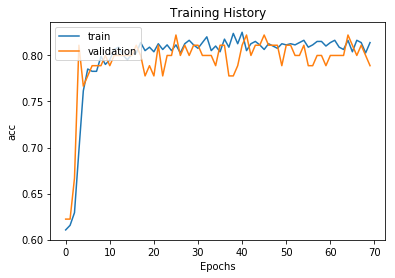

In [11]:
show_train_history(train_history, 'acc', 'val_acc')

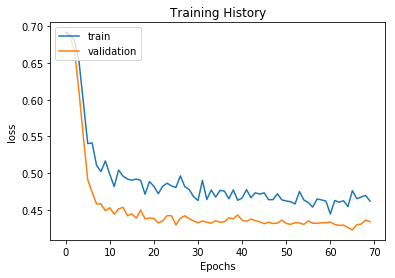

In [12]:
show_train_history(train_history, 'loss', 'val_loss')

### 4.2 Cross Validation

In [14]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

cv_model = KerasClassifier(build_fn=nn_model, epochs=70, batch_size=16, verbose=0)
results = cross_val_score(cv_model, x_train, y_train, cv=kfold)

print("10 Fold Cross Validation Mean Accuracy :", results.mean())

10 Fold Cross Validation Mean Accuracy : 0.819343801566


## Submission

In [15]:
submission = pd.DataFrame({"PassengerId" : test_id, 
                           "Survived" : single_model.predict_classes(x_test).reshape(len(x_test), )})
submission.to_csv("DNN_subm.csv", index = False)

## Homework Comments
與上次 Homework 3結果（80％）比較，使用類神經網路後，效果反而較差（77%），推測導致原因可能有二。

![](https://i.imgur.com/ubomisW.png =400x)

### 1. 類神經網路模型參數設定
由於類神經網路能夠調整之參數繁多（如隱藏層要幾層、節點要幾個等），需要擁有相當經驗，或是耗費相當多時間，尋找最佳參數組合，讓模型達到最佳之效果，而在此次作業中的參數，僅是隨性設定，因此模型很可能未達最佳狀態。

### 2. 訓練資料集過小
在資料量少的情況下，深度學習表現較一般機器學習相差無幾，當資料量變大，才能夠讓深度學習模型更好的學習、調整權重，達到過去方法達不到的效果。而在此次訓練集中僅有891筆，因此表現與上次作業結果相近，甚至小輸。

![](https://i.imgur.com/pFsvavl.png =300x)